If you have the ERA5 data, wave analysis file, and model data collected in one directory and named as in All_figs_data_setup.ipynb, this notebook should be able to replicate Figure 4 in Bartusek et al., 2022, _Nat. Clim. Change_.

Sam Bartusek, 2021

## _Data setup notebook (~15 min)_

In [ ]:
%run ./All_figs_data_setup.ipynb


In [26]:
# Standardize June-mean anomalies:

qq20 = anomjunto20_pnw_mean[['t2mland','sktland','z','swvl1']] / anomjunto20_pnw_mean[['t2mland','sktland','z','swvl1']].sel(time=slice('1981','2010')).std('time')
qq79 = qq20.sel(time=slice('1979','1999'))
qq00 = qq20.sel(time=slice('2000','2020'))
qq21 = anom_jun_pnw_mean[['t2mland','sktland','z','swvl1']].expand_dims(dim='time').assign_coords(time=('time', [datetime.datetime(2021,6,30)])) / anomjunto20_pnw_mean[['t2mland','sktland','z','swvl1']].sel(time=slice('1981','2010')).std('time')
qqyearly = xr.merge([qq20,qq21])


# Calculate correlations between variables:

_,ztcor,ztslope,ztint,ztpval,ztsterr = lag_linregress_3D(qq20.z,qq20.t2mland)
_,ztscor,ztsslope,ztsint,ztspval,ztssterr = lag_linregress_3D(qq20.z,qq20.sktland)
_,stcor,stslope,stint,stpval,ststerr = lag_linregress_3D(qq20.swvl1,qq20.t2mland)
_,stscor,stsslope,stsint,stspval,stssterr = lag_linregress_3D(qq20.swvl1,qq20.sktland)

_,ztcor79,ztslope79,ztint79,ztpval79,ztsterr79 = lag_linregress_3D(qq79.z,qq79.t2mland)
_,ztscor79,ztsslope79,ztsint79,ztspval79,ztssterr79 = lag_linregress_3D(qq79.z,qq79.sktland)
_,stcor79,stslope79,stint79,stpval79,ststerr79 = lag_linregress_3D(qq79.swvl1,qq79.t2mland)
_,stscor79,stsslope79,stsint79,stspval79,stssterr79 = lag_linregress_3D(qq79.swvl1,qq79.sktland)

_,ztcor00,ztslope00,ztint00,ztpval00,ztsterr00 = lag_linregress_3D(qq00.z,qq00.t2mland)
_,ztscor00,ztsslope00,ztsint00,ztspval00,ztssterr00 = lag_linregress_3D(qq00.z,qq00.sktland)
_,stcor00,stslope00,stint00,stpval00,ststerr00 = lag_linregress_3D(qq00.swvl1,qq00.t2mland)
_,stscor00,stsslope00,stsint00,stspval00,stssterr00 = lag_linregress_3D(qq00.swvl1,qq00.sktland)

ts20 = tinv(0.1, len(qq20.t2mland)-2)


## _4a)_

/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Geopotential height [σ]')

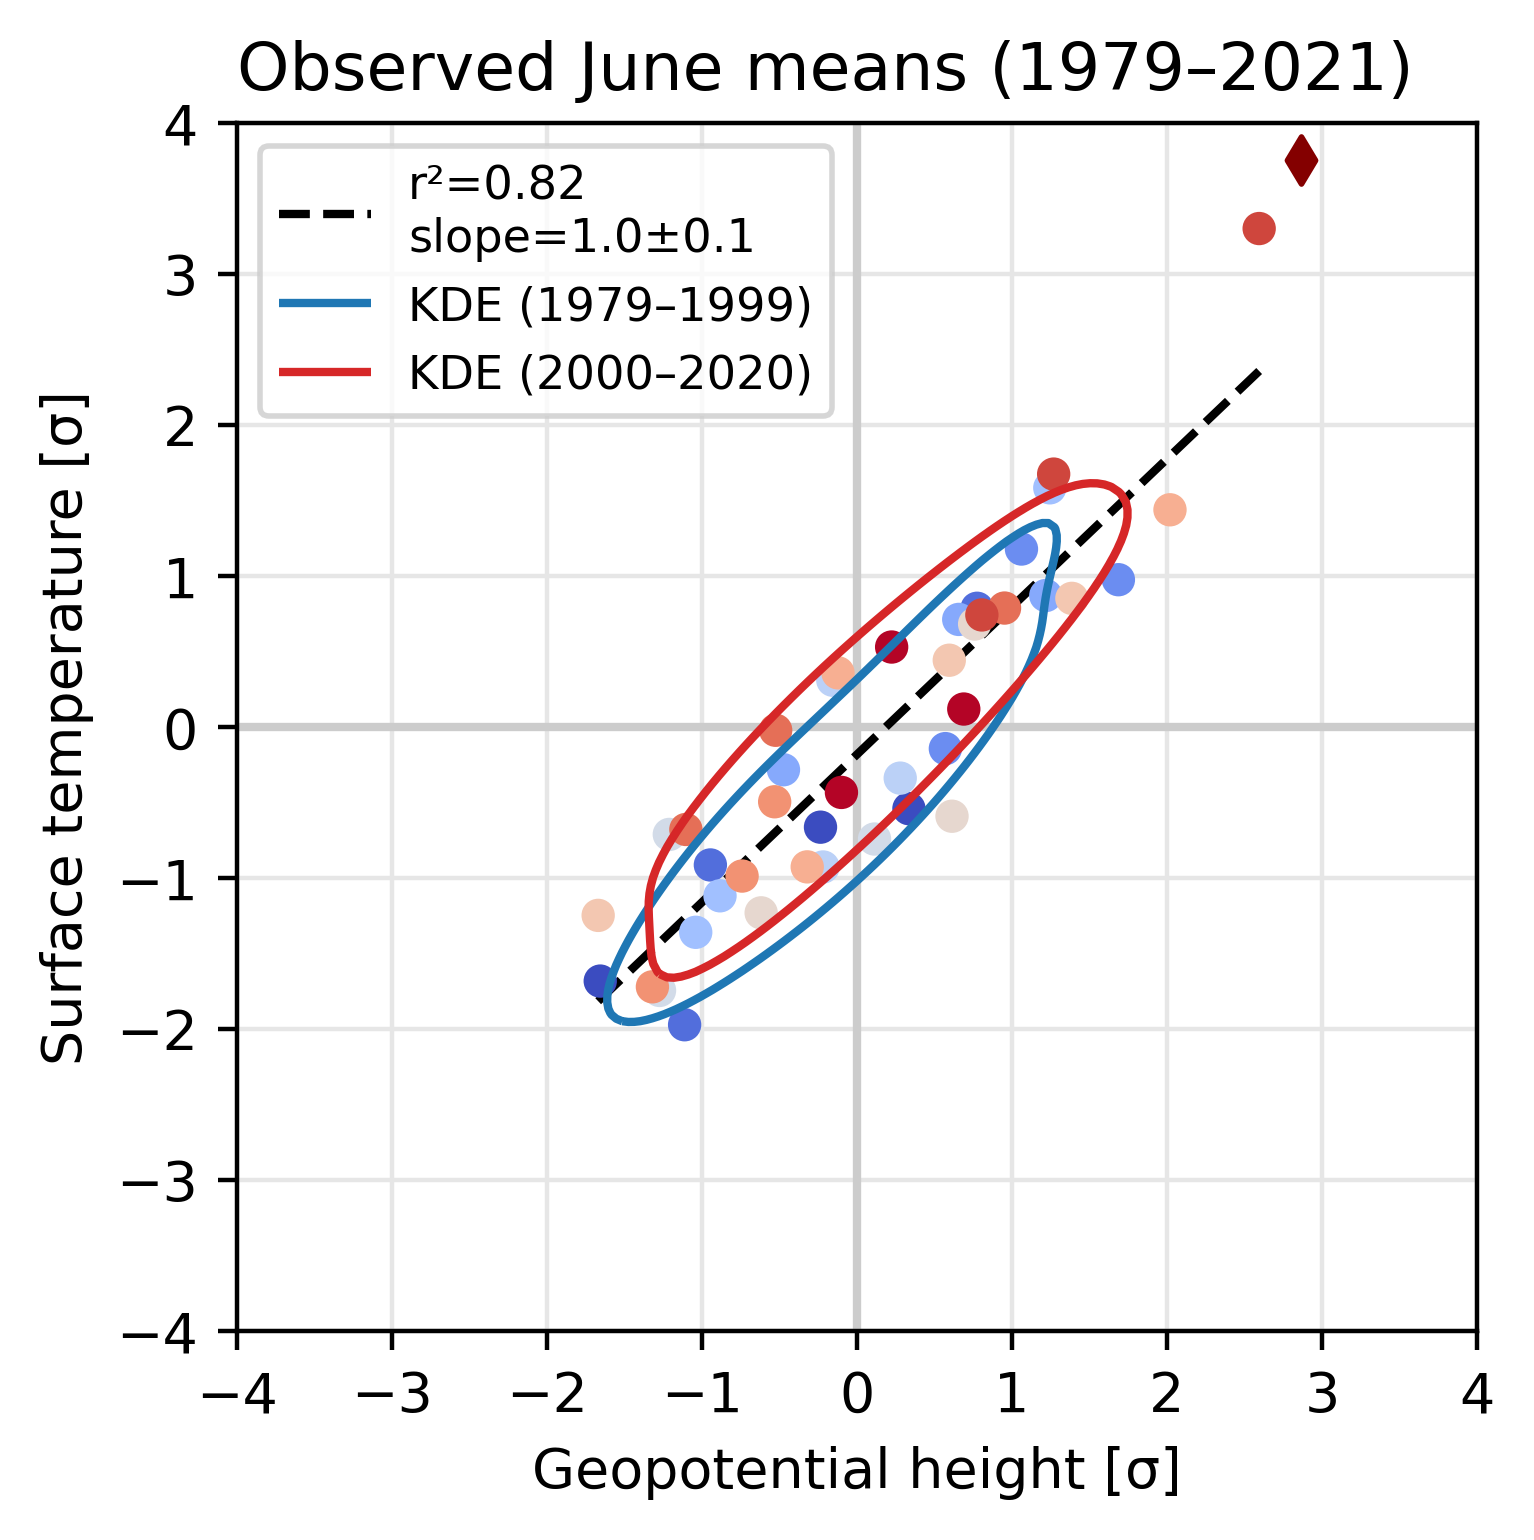

In [27]:
# Plot

fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=200,sharey=True)
cmap1 = cm.get_cmap('coolwarm',14)

ax.axvline(0,c='.8')
ax.axhline(0,c='.8')
ax.grid(c='.9')
ax.scatter(qq20.z,qq20.sktland,c=qq20.time.dt.year,cmap=cmap1,vmax=2021,marker='.',s=100,alpha=1,zorder=101)
xx = np.linspace(qq20.z.min(),qq20.z.max())
ax.plot(xx,ztsslope.values*xx+ztsint.values,ls='--',color='0',label=f'r\N{superscript two}={np.round(ztscor.values**2,2)}\nslope={np.round(ztsslope.values,1)}±{np.round(ts*ztssterr.values,1)}',zorder=100)
sns.kdeplot(qq79.z,qq79.sktland,ax=ax,levels=[.5],bw_adjust=1.25,zorder=101,color='tab:blue',label='KDE (1979–1999)')
sns.kdeplot(qq00.z,qq00.sktland,ax=ax,levels=[.5],bw_adjust=1.25,zorder=101,color='tab:red',label='KDE (2000–2020)')
ax.scatter(qq21.z,qq21.sktland,marker='d',facecolor='xkcd:dark red',zorder=101)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
ax.set_xticks(np.arange(-4,5))
ax.legend(fontsize='small')
ax.set_title('Observed June means (1979–2021)',loc='left')
ax.set_ylabel('Surface temperature [σ]')
ax.set_xlabel('Geopotential height [σ]')


In [30]:
# Import interactive soil moisture model data:

membs = []
for mm in range(1,17):
    ism_ts = xr.open_mfdataset(glob.glob(path + f'CAM5_GOGA/atm_runs/*/i{mm}_TS.nc'), decode_times=False)
    ism_z3 = xr.open_mfdataset(glob.glob(path + f'CAM5_GOGA/atm_runs/*/i{mm}_Z3.nc'), decode_times=False).sel(lev=500).drop('lev')
    ism_mm = xr.merge([ism_ts,ism_z3])
    membs.append(ism_mm)
ism = xr.concat(membs,'member').rename({'lat':'latitude','lon':'longitude','T':'time'})
ism.coords['longitude'] = (ism.coords['longitude'] + 180) % 360 - 180
ism = ism.sortby(ism.longitude).sortby(ism.latitude,ascending=False)
ism = ism.where(ism.latitude>-20,drop=True)
ism['time'] = pd.date_range(start='1856-01-01', periods=ism.sizes['time'], freq='MS') + pd.Timedelta(days=14)
ism = ism.sel(time=slice('1870','2010'))
ism['member'] = ism['member'] + 1
ism['TS'] = ism['TS'] - 273.15
camlandmask = landmask.interp(latitude=ism.latitude,longitude=ism.longitude)
ism['TSland'] = ism['TS'].where(camlandmask>.5)
ism = ism.drop_vars('TS')


# Import prescribed soil moisture model data:

membs = []
for mm in range(1,17):
    psm_ts = xr.open_mfdataset(glob.glob(path + f'CAM5_GOGA_PSM/atm_runs/*/i{mm}_TS.nc'), decode_times=False)
    psm_z3 = xr.open_mfdataset(glob.glob(path + f'CAM5_GOGA_PSM/atm_runs/*/i{mm}_Z3.nc'), decode_times=False).sel(lev=500).drop('lev')
    psm_mm = xr.merge([psm_ts,psm_z3])
    membs.append(psm_mm)
psm = xr.concat(membs,'member').rename({'lat':'latitude','lon':'longitude','T':'time'})
psm.coords['longitude'] = (psm.coords['longitude'] + 180) % 360 - 180
psm = psm.sortby(psm.longitude).sortby(psm.latitude,ascending=False)
psm = psm.where(psm.latitude>-20,drop=True)
psm['time'] = pd.date_range(start='1858-01-01', periods=psm.sizes['time'], freq='MS') + pd.Timedelta(days=14)
psm = psm.sel(time=slice('1870','2010'))
psm['member'] = psm['member'] + 1
psm['TS'] = psm['TS'] - 273.15
psm['TSland'] = psm['TS'].where(camlandmask>.5)
psm = psm.drop_vars('TS')

weights_cam = np.cos(np.deg2rad(psm.latitude))


# Drop runs with data defects

ism = ism.where((ism.member!=5)&(ism.member!=16),drop=True)   
ism['member'] = [x+1 for x in list(range(len(ism.member)))]
psm = psm.where((psm.member!=5)&(psm.member!=16),drop=True) 
psm['member'] = [x+1 for x in list(range(len(psm.member)))]


# Take anomalies w.r.t. 1981–2010

ism_anom = (ism.groupby('time.month') - ism.sel(time=slice('1981','2010')).groupby('time.month').mean('time'))
psm_anom = (psm.groupby('time.month') - psm.sel(time=slice('1981','2010')).groupby('time.month').mean('time'))


# Isolate Junes

ism_junidxs=ism.groupby('time.month').groups[6]
ism_jun=ism.isel(time=ism_junidxs)
ism_anom_jun=ism_anom.isel(time=ism_junidxs)

psm_junidxs=psm.groupby('time.month').groups[6]
psm_jun=psm.isel(time=psm_junidxs)
psm_anom_jun=psm_anom.isel(time=psm_junidxs)


# Take June-mean PNW-means

ism_jun_pnw_mean = ism_jun.sel(latitude=pnwlat,longitude=pnwlon).mean('longitude').weighted(weights_cam).mean('latitude')
psm_jun_pnw_mean = psm_jun.sel(latitude=pnwlat,longitude=pnwlon).mean('longitude').weighted(weights_cam).mean('latitude')

ism_anom_jun_pnw_mean = ism_anom_jun.sel(latitude=pnwlat,longitude=pnwlon).mean('longitude').weighted(weights_cam).mean('latitude')
psm_anom_jun_pnw_mean = psm_anom_jun.sel(latitude=pnwlat,longitude=pnwlon).mean('longitude').weighted(weights_cam).mean('latitude')


# Normalize by grouped std. dev.

tt = slice('1981','2010')
tt2 = slice('1870','2010')

ptest = xr.zeros_like(psm_anom_jun_pnw_mean)
itest = xr.zeros_like(ism_anom_jun_pnw_mean)
for vv in psm_anom_jun_pnw_mean.data_vars:
    ptest[vv] = psm_anom_jun_pnw_mean[vv] / np.std(psm_anom_jun_pnw_mean.sel(time=tt2)[vv].values.ravel())
    itest[vv] = ism_anom_jun_pnw_mean[vv] / np.std(psm_anom_jun_pnw_mean.sel(time=tt2)[vv].values.ravel())
del psm_anom_jun_pnw_mean
psm_anom_jun_pnw_mean = ptest
del ism_anom_jun_pnw_mean
ism_anom_jun_pnw_mean = itest


# Load into memory

with pbar:
    psm_anom_jun_pnw_mean.load()
    ism_anom_jun_pnw_mean.load()
    
    
# Calculate correlations between variables

ztslopep,ztintp,ztcorp,ztpvalp,ztsterrp = scipy.stats.linregress(psm_anom_jun_pnw_mean.Z3.values.ravel(),
                                                                 psm_anom_jun_pnw_mean.TSland.values.ravel())
ztslopei,ztinti,ztcori,ztpvali,ztsterri = scipy.stats.linregress(ism_anom_jun_pnw_mean.Z3.values.ravel(),
                                                                 ism_anom_jun_pnw_mean.TSland.values.ravel())
ts = tinv(0.1, len(psm_anom_jun_pnw_mean.TSland.values.ravel())-2)


# Calculate ratios between variable std. dev.s

prug = psm_anom_jun_pnw_mean.sel(time=tt2).TSland.std('time') / psm_anom_jun_pnw_mean.sel(time=tt2).Z3.std('time')
pgroup = np.std(psm_anom_jun_pnw_mean.sel(time=tt2).TSland.values.ravel()) / np.std(psm_anom_jun_pnw_mean.sel(time=tt2).Z3.values.ravel())
irug = ism_anom_jun_pnw_mean.sel(time=tt2).TSland.std('time') / ism_anom_jun_pnw_mean.sel(time=tt2).Z3.std('time')
igroup = np.std(ism_anom_jun_pnw_mean.sel(time=tt2).TSland.values.ravel()) / np.std(ism_anom_jun_pnw_mean.sel(time=tt2).Z3.values.ravel())



/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/o

[########################################] | 100% Completed | 32.0s
[########################################] | 100% Completed | 29.6s


## _4b)_

/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/pangeoxtdai36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


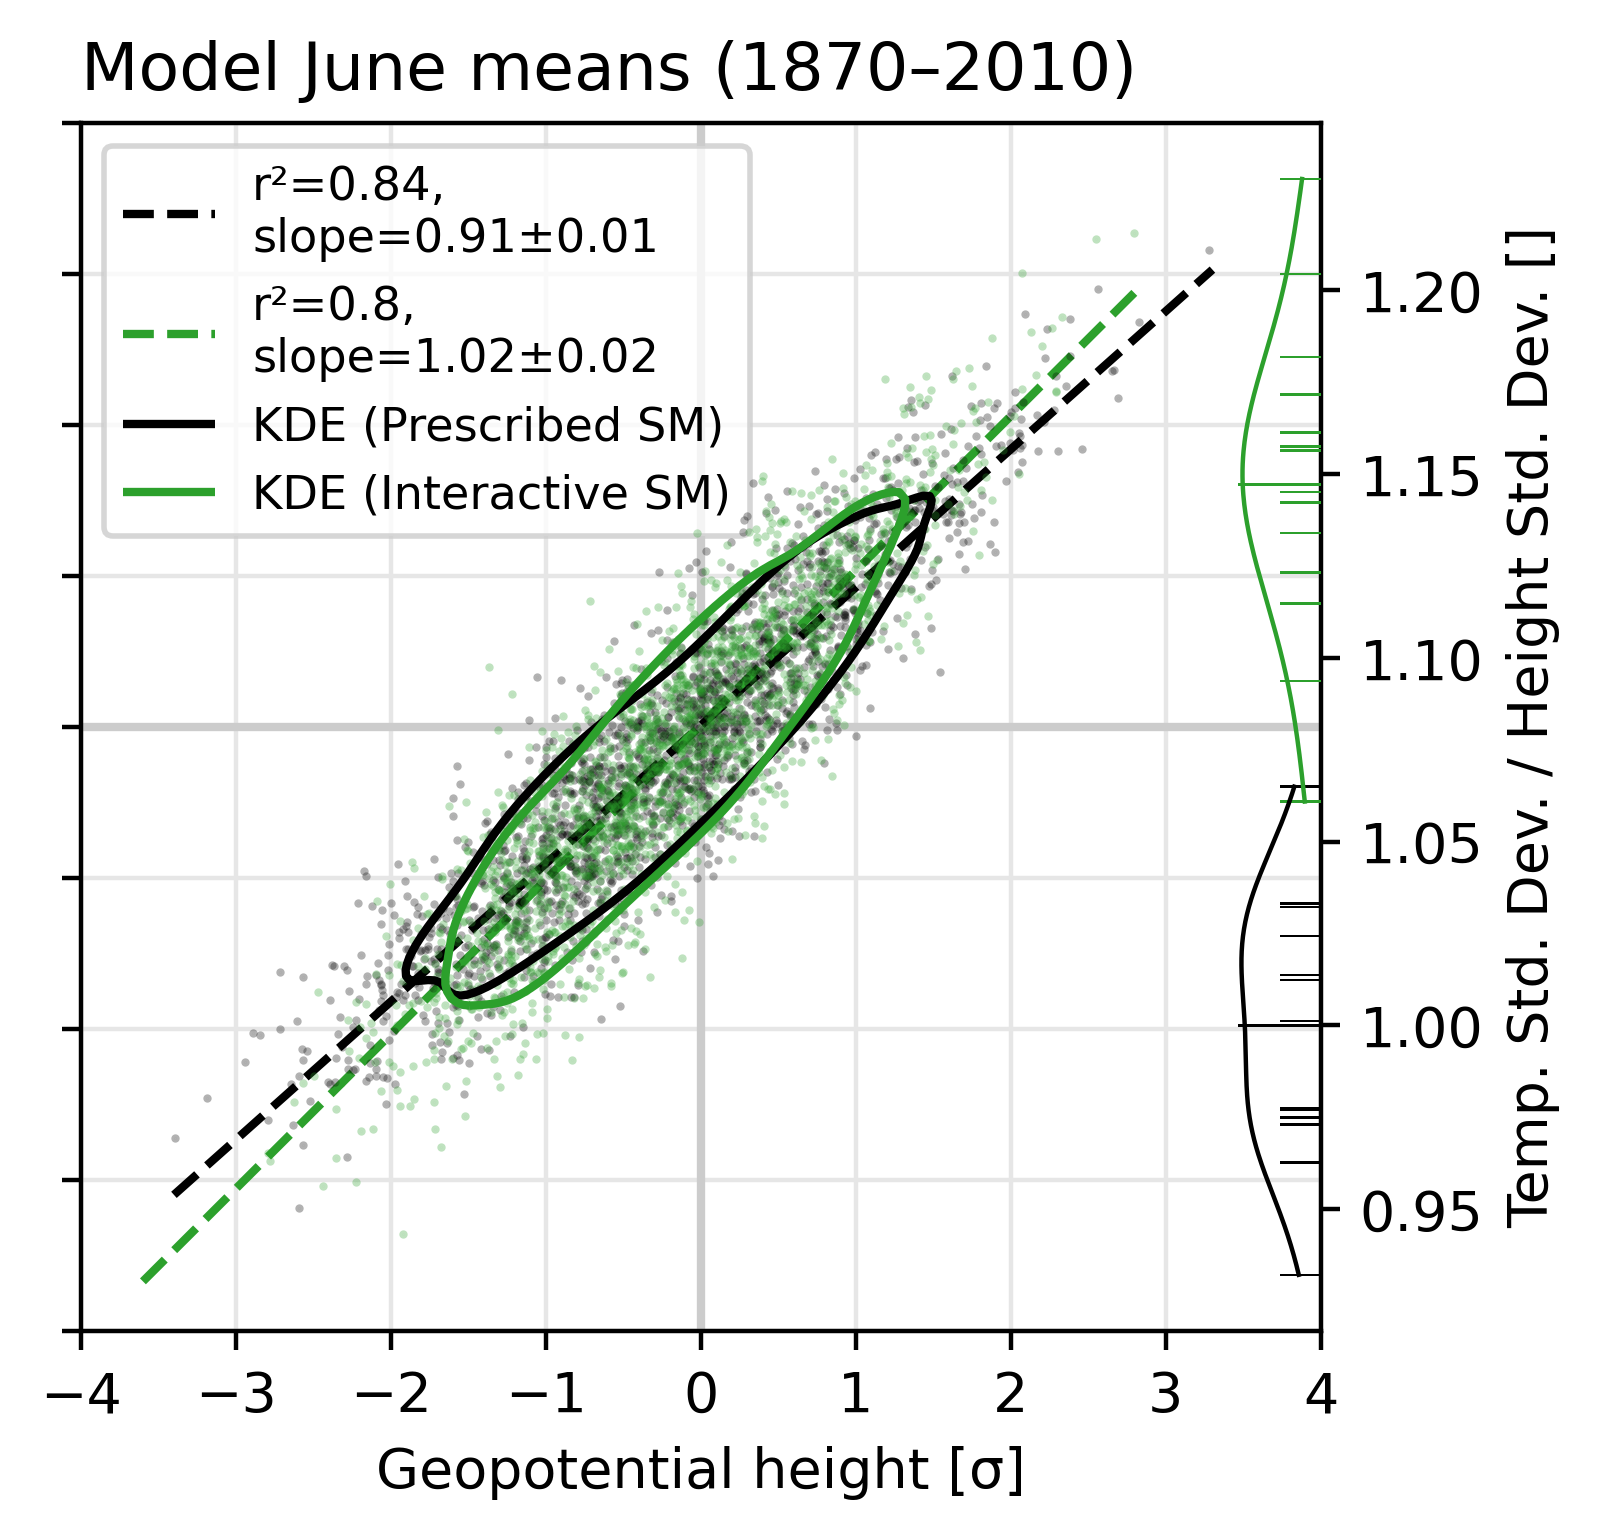

In [31]:
# Plot

fig,axs = plt.subplots(1,1,figsize=(4,4),dpi=200)
cmap1 = cm.get_cmap('coolwarm',14)

ax = axs
ax.axvline(0,c='.8')
ax.axhline(0,c='.8')
ax.grid(c='.9')
ax.scatter(psm_anom_jun_pnw_mean.Z3.values.ravel(),psm_anom_jun_pnw_mean.TSland.values.ravel(),color='0',marker='.',s=1,alpha=.3,zorder=101)
ax.scatter(ism_anom_jun_pnw_mean.Z3.values.ravel(),ism_anom_jun_pnw_mean.TSland.values.ravel(),color='tab:green',marker='.',s=1,alpha=.3,zorder=101)
sns.kdeplot(psm_anom_jun_pnw_mean.Z3.values.ravel(),psm_anom_jun_pnw_mean.TSland.values.ravel(),ax=ax,levels=[.3],linestyles='-',bw_adjust=1,zorder=101,color='0',label='KDE (Prescribed SM)')
sns.kdeplot(ism_anom_jun_pnw_mean.Z3.values.ravel(),ism_anom_jun_pnw_mean.TSland.values.ravel(),ax=ax,levels=[.3],linestyles='-',bw_adjust=1,zorder=101,color='tab:green',label='KDE (Interactive SM)')
xx = np.arange(np.round(psm_anom_jun_pnw_mean.Z3.min(),1),np.round(psm_anom_jun_pnw_mean.Z3.max(),1)+.1,.1)
ax.plot(xx,ztslopep*xx+ztintp,ls='--',color='0',label=f'r\N{superscript two}={np.round(ztcorp**2,2)},\nslope={np.round(ztslopep,2)}±{np.round(ts*ztsterrp,2)}',zorder=100)
xx = np.arange(np.round(ism_anom_jun_pnw_mean.Z3.min(),1),np.round(ism_anom_jun_pnw_mean.Z3.max(),1)+.1,.1)
ax.plot(xx,ztslopei*xx+ztinti,ls='--',color='tab:green',label=f'r\N{superscript two}={np.round(ztcori**2,2)},\nslope={np.round(ztslopei,2)}±{np.round(ts*ztsterri,2)}',zorder=100)
ax.set_xlim(-4,4)
ax.set_xticks(np.arange(-4,5))
ax.set_ylim(-4,4)
ax.legend(loc='upper left',fontsize='small')
ax.set_title('Model June means (1870–2010)',loc='left')
ax.set_ylabel('')
ax.yaxis.set_ticklabels([])
ax.set_xlabel('Geopotential height [σ]')

ax2 = fig.add_subplot(111, frame_on=False)
sns.kdeplot(y=prug,ax=ax2,color='0',lw=.8,cut=0)
sns.kdeplot(y=irug,ax=ax2,color='tab:green',lw=.8,cut=0)
xlim = ax2.get_xlim()[1]*15
ax2.set_xlim(xlim,0)
ylim = ax2.get_ylim()[1] - ax2.get_ylim()[0]
ax2.barh(prug,xlim/30,ylim/500,color='0')
ax2.barh(irug,xlim/30,ylim/500,color='tab:green')
ax2.barh(pgroup,xlim/15,ylim/500,color='0')
ax2.barh(igroup,xlim/15,ylim/500,color='tab:green')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xticks([])
ax2.set_ylabel('Temp. Std. Dev. / Height Std. Dev.')  
ax2.set_xlabel('')  
ax2.yaxis.set_label_position('right') 


In [32]:
# Calculate KDEs of each ensemble member and grouped members

points = np.arange(-4,4.01,.01)
p21 = np.argwhere(np.round(points,2)==np.round(qq21.sktland.values[0],2))[0][0]

kdes_psm_ts = np.ones((len(ism.member),len(points)))
kdes_ism_ts = np.ones((len(ism.member),len(points)))
isurvivals = np.ones((len(ism.member),len(points)))
psurvivals = np.ones((len(ism.member),len(points)))

for mm in range(len(ism.member)):
    kkp = scipy.stats.gaussian_kde(psm_anom_jun_pnw_mean.TSland.isel(member=mm))
    kki = scipy.stats.gaussian_kde(ism_anom_jun_pnw_mean.TSland.isel(member=mm))
    kdes_psm_ts[mm,:] = kkp.evaluate(points)
    kdes_ism_ts[mm,:] = kki.evaluate(points)
    psurvivals[mm,:] = np.array([1-kkp.integrate_box_1d(points[0],pp) for pp in points])
    isurvivals[mm,:] = np.array([1-kki.integrate_box_1d(points[0],pp) for pp in points])
    
kkp = scipy.stats.gaussian_kde(psm_anom_jun_pnw_mean.TSland.values.ravel())
kki = scipy.stats.gaussian_kde(ism_anom_jun_pnw_mean.TSland.values.ravel())
kde_psm_ts_all = kkp.evaluate(points)
kde_ism_ts_all = kki.evaluate(points)
psurvivals_all = np.array([1-kkp.integrate_box_1d(points[0],pp) for pp in points])
isurvivals_all = np.array([1-kki.integrate_box_1d(points[0],pp) for pp in points])
    

## _4c)_

Text(0, 0.5, 'Probability density')

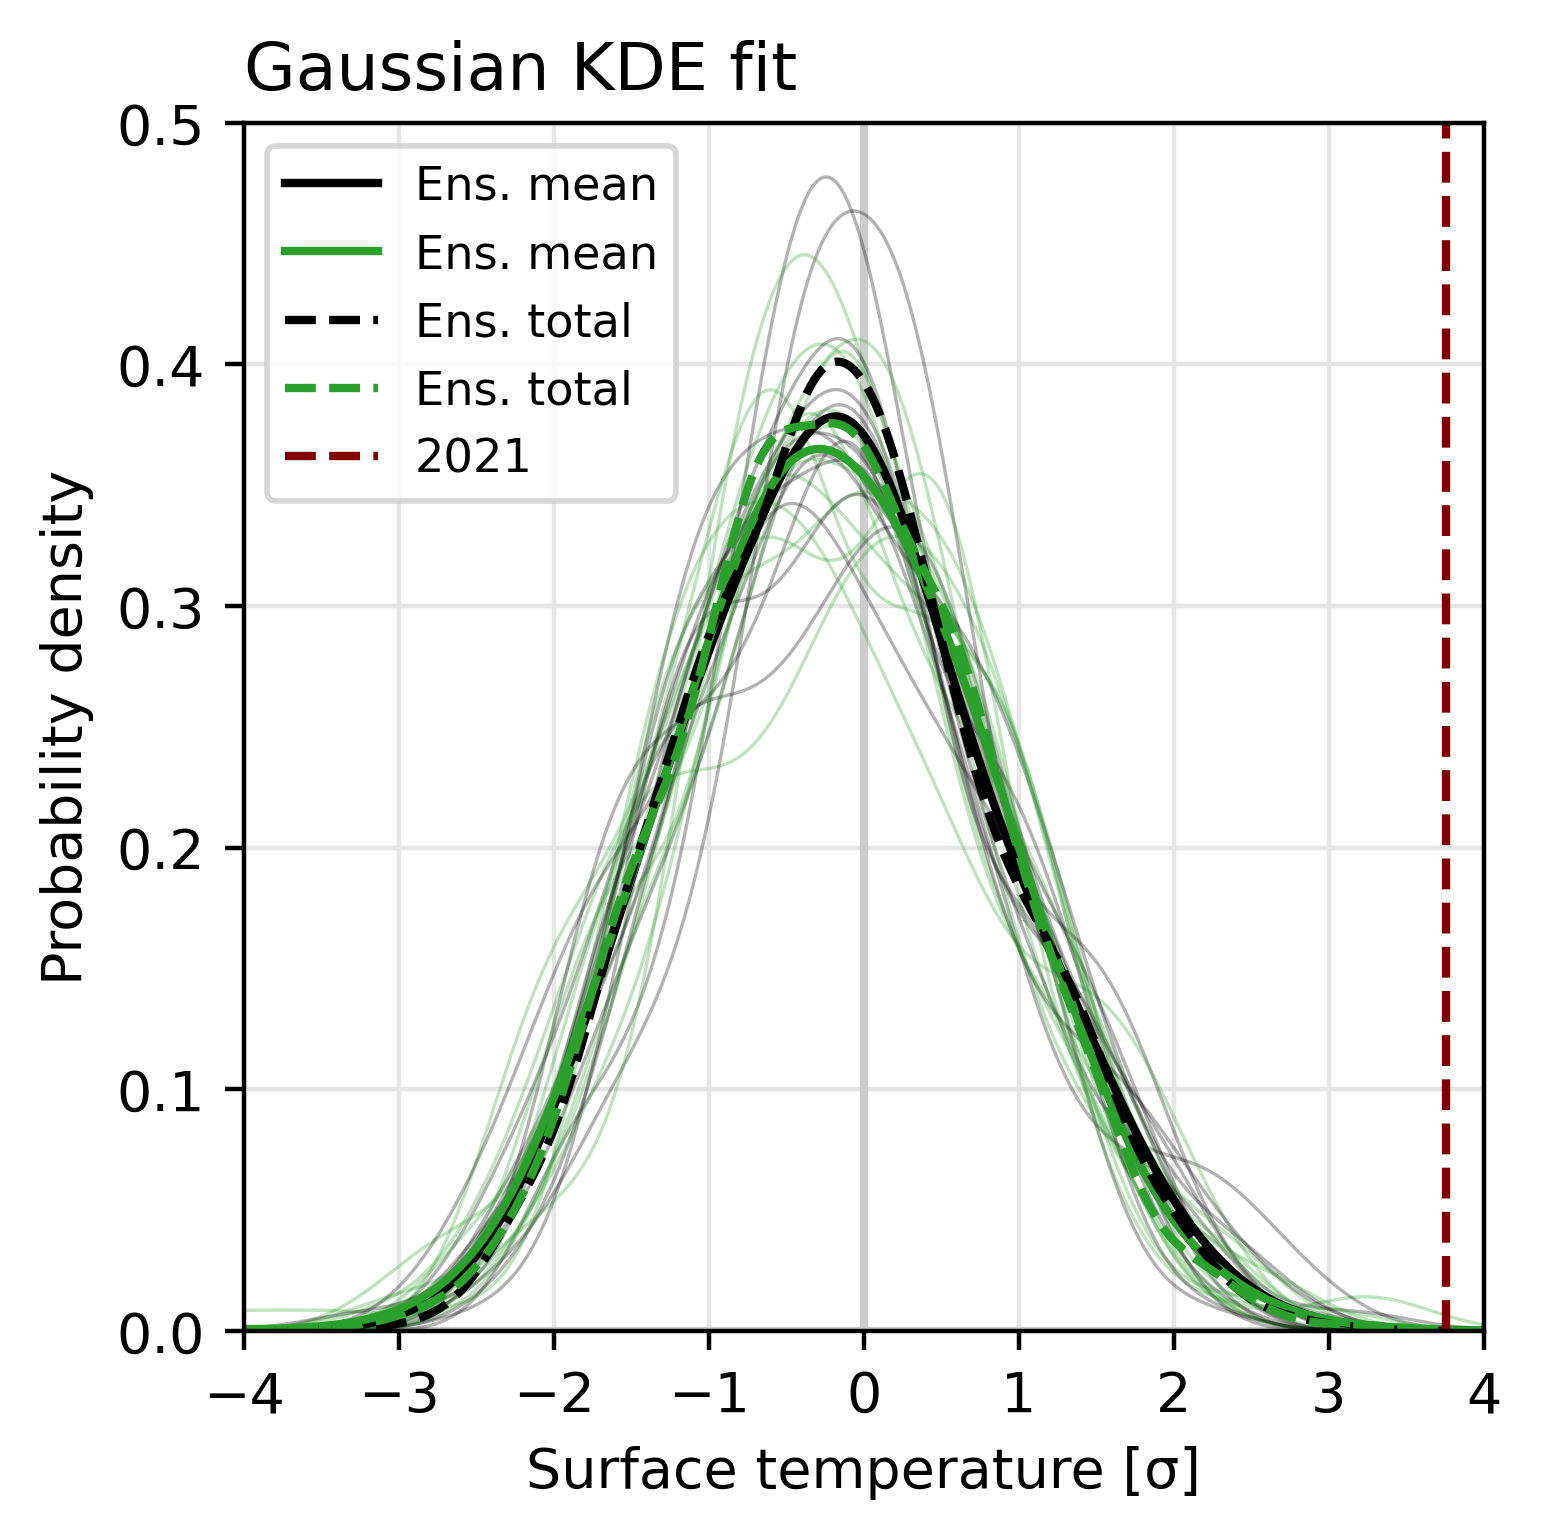

In [33]:
# Plot

plt.figure(dpi=200,figsize=(4,4))
plt.axvline(0,c='.8')
plt.axhline(0,c='.8')
plt.grid(c='.9')
plt.plot(points,kdes_psm_ts[0,:],ls='-',color='0',lw=.6,alpha=.3)
plt.plot(points,kdes_ism_ts[0,:],ls='-',color='tab:green',lw=.6,alpha=.3)
for mm in range(1,len(ism.member)):
    plt.plot(points,kdes_psm_ts[mm,:],ls='-',color='0',lw=.6,alpha=.3)
    plt.plot(points,kdes_ism_ts[mm,:],ls='-',color='tab:green',lw=.6,alpha=.3)
plt.plot(points,np.mean(kdes_psm_ts,0),lw=1.5,color='0',alpha=1,label='Ens. mean')
plt.plot(points,np.mean(kdes_ism_ts,0),lw=1.5,color='tab:green',alpha=1,label='Ens. mean')
plt.plot(points,kde_psm_ts_all,lw=1.5,ls='--',color='0',alpha=1,label='Ens. total') 
plt.plot(points,kde_ism_ts_all,lw=1.5,ls='--',color='tab:green',alpha=1,label='Ens. total')
plt.axvline(qq21.sktland,c='xkcd:dark red',ls='--',label='2021')

plt.legend(loc='upper left',fontsize='small')
plt.xlim(-4,4)
plt.ylim(0,.5)
plt.xticks(np.arange(-4,5))
plt.ylim(0)
plt.title('Gaussian KDE fit',loc='left')
plt.xlabel('Surface temperature [σ]')
plt.ylabel('Probability density')


In [ ]:
# Calculate KDE of grouped members with many bootstrap realizations

reps = 5000  # takes ~20-30 min for 5000

n = len(psm_anom_jun_pnw_mean.TSland.values.ravel())
xb_psm = np.random.choice(psm_anom_jun_pnw_mean.TSland.values.ravel(), (n, reps))
xb_ism = np.random.choice(ism_anom_jun_pnw_mean.TSland.values.ravel(), (n, reps))
kde_psm_ts_all_b = np.zeros((len(points),reps))
kde_ism_ts_all_b = np.zeros((len(points),reps))
psurvivals_all_b = np.zeros((len(points),reps))
isurvivals_all_b = np.zeros((len(points),reps))
for xx in range(reps):
    kk = scipy.stats.gaussian_kde(xb_psm[:,xx])
    kde_psm_ts_all_b[:,xx] = kk.evaluate(points)
    psurvivals_all_b[:,xx] = [1-kk.integrate_box_1d(points[0],pp) for pp in points]
    kk = scipy.stats.gaussian_kde(xb_ism[:,xx])
    kde_ism_ts_all_b[:,xx] = kk.evaluate(points)
    isurvivals_all_b[:,xx] = [1-kk.integrate_box_1d(points[0],pp) for pp in points]
    
    if not xx % 100:
        print(xx)
    

# Take percentiles of bootstrap realizations for confidence intervals

kde_psm_ts_all_5,kde_psm_ts_all_10,kde_psm_ts_all_125,kde_psm_ts_all_25,kde_psm_ts_all_50,kde_psm_ts_all_75,kde_psm_ts_all_875,kde_psm_ts_all_90,kde_psm_ts_all_95 = np.percentile(kde_psm_ts_all_b,[5,10,12.5,25,50,75,87.5,90,95],axis=1)
kde_ism_ts_all_5,kde_ism_ts_all_10,kde_ism_ts_all_125,kde_ism_ts_all_25,kde_ism_ts_all_50,kde_ism_ts_all_75,kde_ism_ts_all_875,kde_ism_ts_all_90,kde_ism_ts_all_95 = np.percentile(kde_ism_ts_all_b,[5,10,12.5,25,50,75,87.5,90,95],axis=1)
psurvivals_all_5,psurvivals_all_10,psurvivals_all_125,psurvivals_all_25,psurvivals_all_50,psurvivals_all_75,psurvivals_all_875,psurvivals_all_90,psurvivals_all_95 = np.percentile(psurvivals_all_b,[5,10,12.5,25,50,75,87.5,90,95],axis=1)
isurvivals_all_5,isurvivals_all_10,isurvivals_all_125,isurvivals_all_25,isurvivals_all_50,isurvivals_all_75,isurvivals_all_875,isurvivals_all_90,isurvivals_all_95 = np.percentile(isurvivals_all_b,[5,10,12.5,25,50,75,87.5,90,95],axis=1)


## _4d)_

Text(0.0, 1.0, 'Event probability and return period')

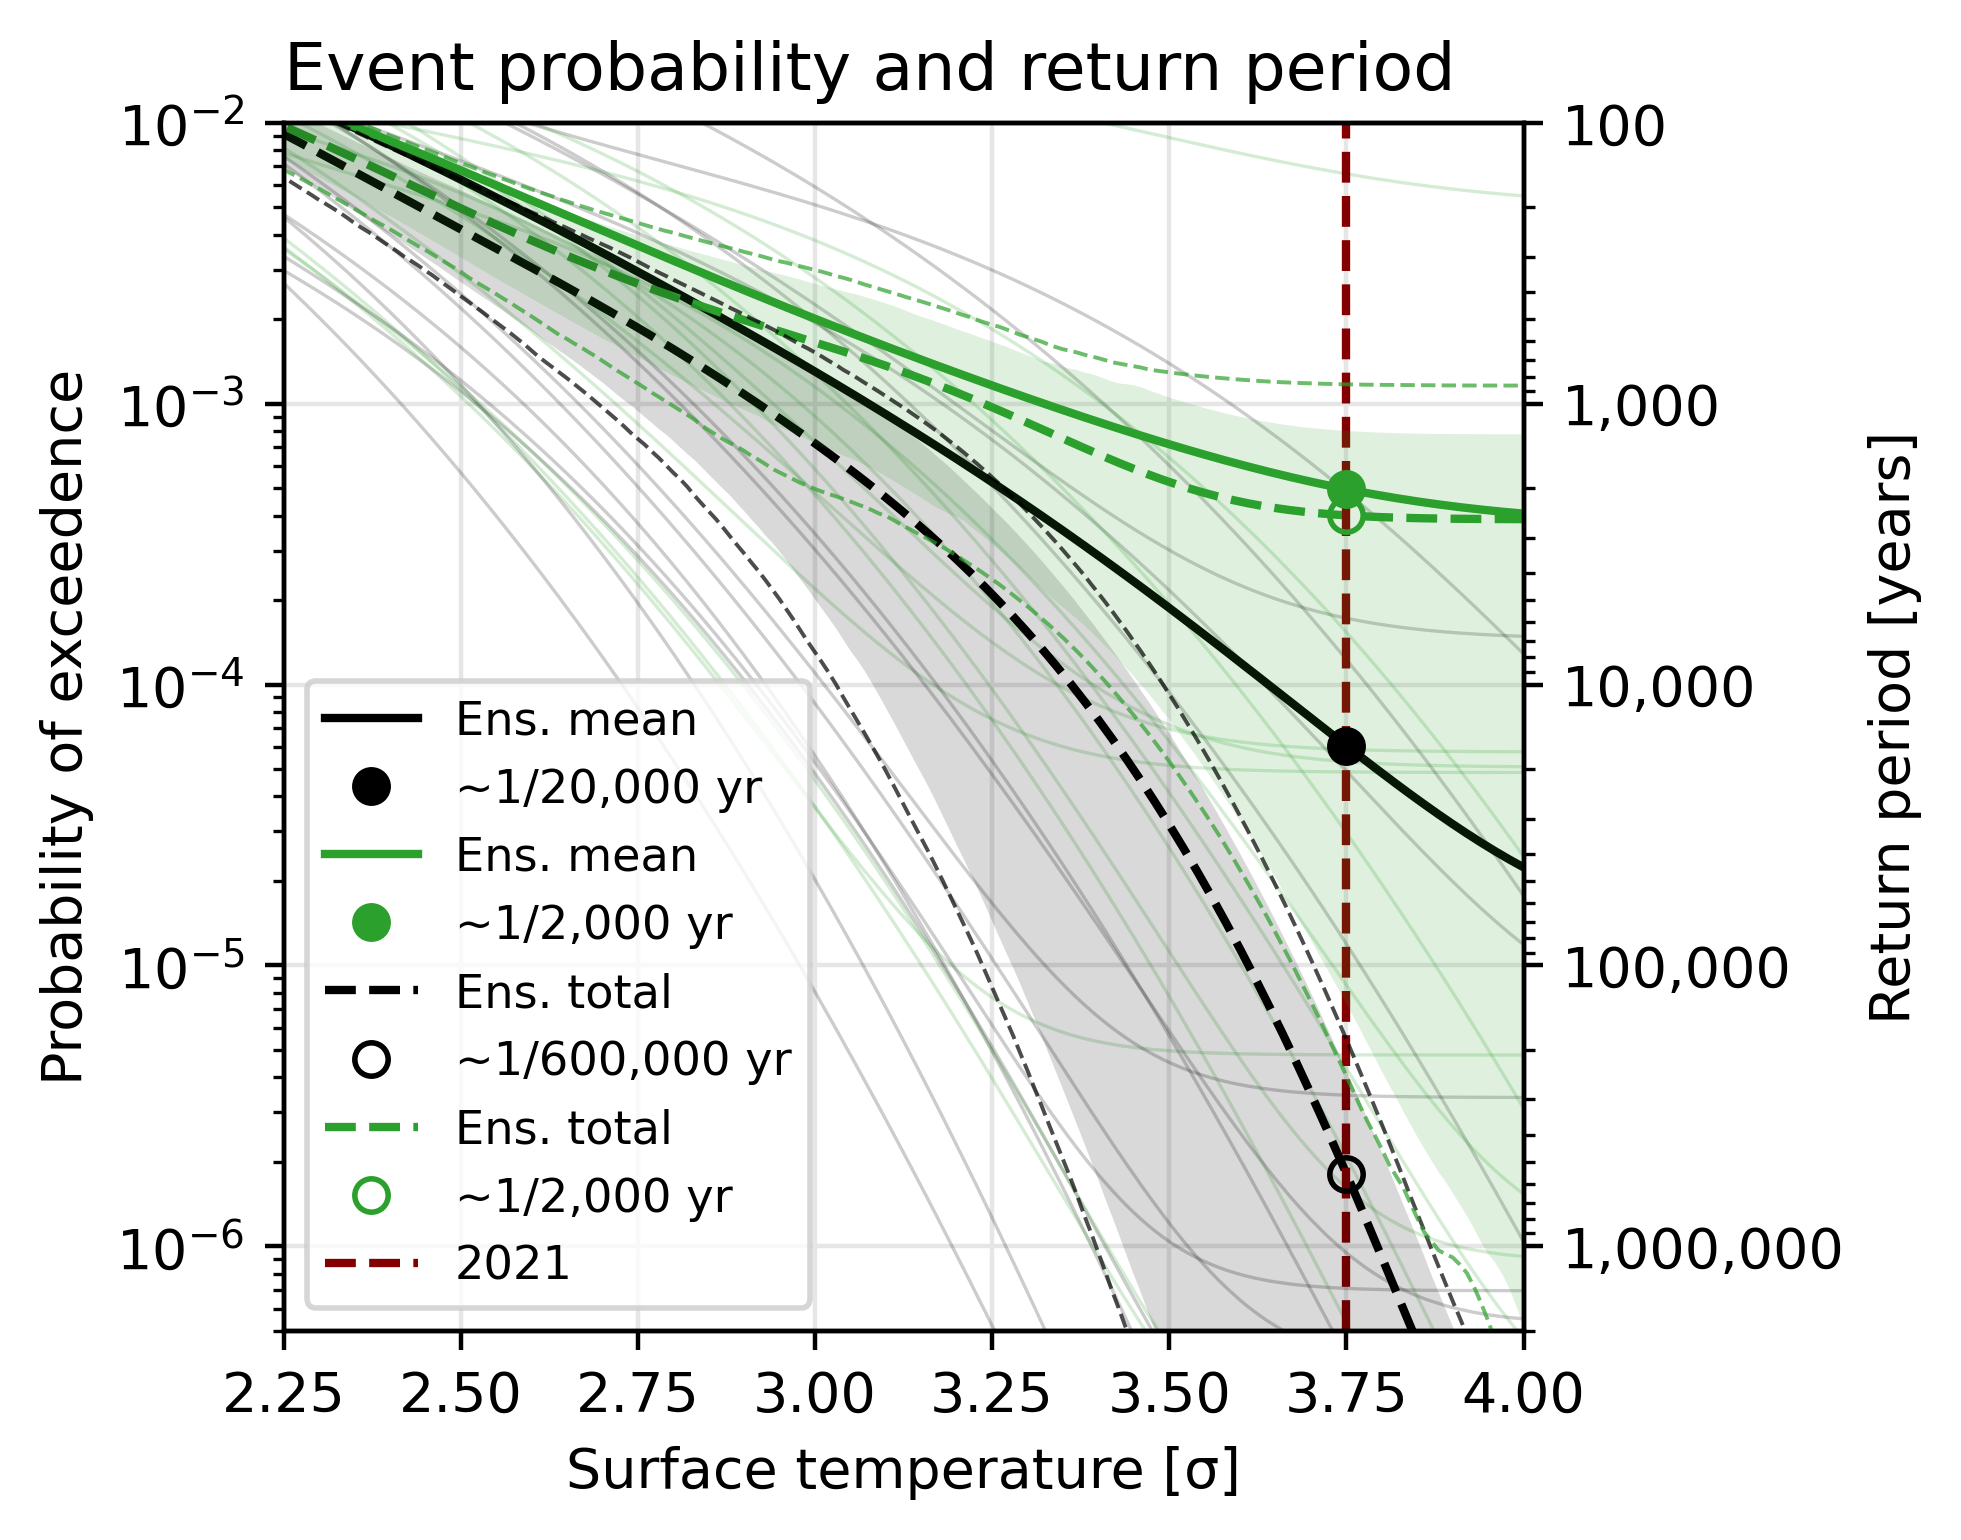

In [150]:
# Plot

fig,ax = plt.subplots(1,1,dpi=200,figsize=(4,4))

ax.grid(c='.9',zorder=1)
for mm in range(len(ism.member)):
    ax.plot(points,psurvivals[mm,:],color='0',ls='-',lw=.6,alpha=.2)
    ax.plot(points,isurvivals[mm,:],color='tab:green',ls='-',lw=.6,alpha=.2)
ax.plot(points,np.mean(psurvivals,0),color='0',lw=1.5,label='Ens. mean')
ax.plot(points[p21],np.mean(psurvivals,0)[p21],color='0',ls='none',marker='o',label=f'~1/{int(round_to_n(1/np.mean(psurvivals,0)[p21],1)):,} yr',zorder=101)
ax.plot(points,np.mean(isurvivals,0),color='tab:green',lw=1.5,label='Ens. mean')
ax.plot(points[p21],np.mean(isurvivals,0)[p21],color='tab:green',ls='none',marker='o',label=f'~1/{int(round_to_n(1/np.mean(isurvivals,0)[p21],1)):,} yr',zorder=101)
ax.plot(points,psurvivals_all,color='0',ls='--',lw=1.5,label='Ens. total')
ax.plot(points,psurvivals_all_5,color='0',ls='--',lw=.7,alpha=.7,zorder=500)
ax.plot(points,psurvivals_all_95,color='0',ls='--',lw=.7,alpha=.7,zorder=500)
ax.plot(points[p21],psurvivals_all[p21],color='0',ls='none',marker='o',markerfacecolor='none',label=f'~1/{int(round_to_n(1/psurvivals_all[p21],1)):,} yr',zorder=101)
ax.fill_between(points,psurvivals_all_10,psurvivals_all_90,color='0',alpha=.15,edgecolor='none',zorder=3)
ax.plot(points,isurvivals_all,color='tab:green',ls='--',lw=1.5,label='Ens. total')
ax.plot(points,isurvivals_all_5,color='tab:green',ls='--',lw=.7,alpha=.7,zorder=500)
ax.plot(points,isurvivals_all_95,color='tab:green',ls='--',lw=.7,alpha=.7,zorder=500)
ax.plot(points[p21],isurvivals_all[p21],color='tab:green',ls='none',marker='o',markerfacecolor='none',label=f'~1/{int(round_to_n(1/isurvivals_all[p21],1)):,} yr',zorder=101)
ax.fill_between(points,isurvivals_all_10,isurvivals_all_90,color='tab:green',alpha=.15,edgecolor='none',zorder=3)
ax.axvline(np.round(qq21.sktland.values,2),c='xkcd:dark red',ls='--',label='2021')

ax.legend(fontsize='small',loc='lower left')
ax.set_xlim(2.25,4)
ax.set_ylim(5e-7,1e-2)
ax.set_yscale('log')
ax.set_xlabel('Surface temperature [σ]')
ax.set_ylabel('Probability of exceedence')

ax2 = ax.twinx()
ymin, ymax = ax.get_ylim()
ax2.set_ylim((1/ymin),(1/ymax))
ax2.set_yscale('log')
ax2.plot([],[])
ax2.set_ylabel('Return period [years]')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:,.16g}'.format(y)))

plt.title('Event probability and return period',loc='left')
    